In [2]:
# put the directory path to your LMR repository here
import sys
sys.path.append("/Users/dan/Desktop/LMR_py3/")
!cd /Users/dan/Desktop/LMR_py3

# prefix for figure filename
fig_prefix='prior_truth_'

In [3]:
import LMR_lite_utils as LMRlite
import LMR_utils
import LMR_config
import numpy as np
import os,sys
from time import time
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point
%matplotlib inline

Loading information from datasets.yml
Loading information from grid_def.yml


In [12]:
# Load and interpolate all of the priors I want to use as truth

lmr_names = ['ccsm4_last_millenium',
             'mpi-esm-p_last_millenium',
             'hadcm3_last_millenium']
model_names = ['CCSM4','MPI-ESM','HadCM3']

# Initialize an array of various interpolated model fields
ad = []

for ii in np.arange(len(lmr_names)):
    dd = {}
    cfile = './configs/config.yml.nullspace.'+lmr_names[ii]
    yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)
    cfg = LMRlite.load_config(yaml_file)
    
    X, Xb_one = LMRlite.load_prior(cfg)
    Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)
    
    # check if config is set to regrid the prior
    if cfg.prior.regrid_method:
        print('regridding prior...')
        # this function over-writes X, even if return is given a different name
        [X,Xb_one_new] = LMRlite.prior_regrid(cfg,X,Xb_one,verbose=False)
    else:
        X.trunc_state_info = X.full_state_info
    
    Xb_one = Xb_one_new
    Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)
    grid = LMRlite.Grid(X)    
    
    dd['X']        = X
    dd['Xbp']      = Xbp
    dd['name']     = model_names[ii]
    dd['lmr_name'] = lmr_names[ii]
    dd['grid']     = grid

    print(ii)
    print(dd['name'])

    ad.append(dd)

np.save('/Users/dan/Desktop/Nullspace/pt_out/ad',ad)


Checking configuration ... 
OK!
Reading file:  /Users/dan/Desktop/LMR_py3/data/model/ccsm4_last_millenium/tas_sfc_Amon_CCSM4_past1000_085001-185012.nc
(12012, 192, 288)
indlat= 0  indlon= 1
Anomalies provided as the prior: Removing the temporal mean (for every gridpoint)...
tas : Global(monthly): mean= 8.072375e-07  , std-dev= 1.8899411
Averaging over month sequence: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
tas : Global(time-averaged): mean= 4.4424884352419226e-08  , std-dev= 0.8317386411161235
 
State vector information:
Nx = 55296
state_vect_info= {'tas_sfc_Amon': {'pos': (0, 55295), 'spacecoords': ('lat', 'lon'), 'spacedims': (192, 288), 'vartype': '2D:horizontal'}}
Random selection of 100 ensemble members
regridding prior...
tas_sfc_Amon  : 2D lat/lon variable, truncating this variable
=> Full array:      -11.247562408447266 7.616621494293213 -0.007214761114431409 0.8384257279438592
=> Truncated array: -11.101190125702887 7.239956964122407 -0.007491004016465484 0.8339612765545283
0


In [39]:
def plot_3x3(cdd,grid):

    import cartopy.util as cutil
    import cartopy.crs as ccrs
    from cartopy.mpl.geoaxes import GeoAxes
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    from mpl_toolkits.axes_grid1 import AxesGrid
    import matplotlib.cm as cm

    projection = ccrs.PlateCarree(central_longitude=0.)
    axes_class = (GeoAxes,
                  dict(map_projection=projection))

    fig = plt.figure(figsize=(16,12))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(3, 3),
                    axes_pad=0.6,
                    cbar_location='right',
                    cbar_mode='each',
    #                cbar_mode='single',
    #                cbar_pad=0.2,
    #                cbar_size='3%',
    #                cbar_set_cax=False,
                    label_mode='')  # note the empty label_mode

    for ii, ax in enumerate(axgr):

        rmsc = cdd[ii]['rmse']

        cldat = rmsc.reshape(grid.nlat,grid.nlon)
        wrap_data, wrap_lon = cutil.add_cyclic_point(cldat, coord=grid.lon[0,:], axis=1)

        plt.sca(axgr[ii])
        max
        p=plt.contourf(wrap_lon,grid.lat[:,0],wrap_data,#np.arange(0,2.0,.05),
                        transform=projection,
#                        extend='max',
                        cmap='YlOrRd'
                        )

        ax.coastlines(color='gray')
        if cdd[ii]['pind']==2:
            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            ax.xaxis.set_major_formatter(lon_formatter)
            ax.set_xticks(np.linspace(-180, 180, 5), crs=projection)

        if cdd[ii]['tind'] == 0:
            ax.set_yticks(np.linspace(-80, 80, 5), crs=projection)
            lat_formatter = LatitudeFormatter()
            ax.yaxis.set_major_formatter(lat_formatter)

        plt.colorbar()

    cb=axgr.cbar_axes[0].colorbar(p)
    plt.show()

    #fig.savefig('Figs/rmse_complete_obs.pdf', bbox_inches='tight')


/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


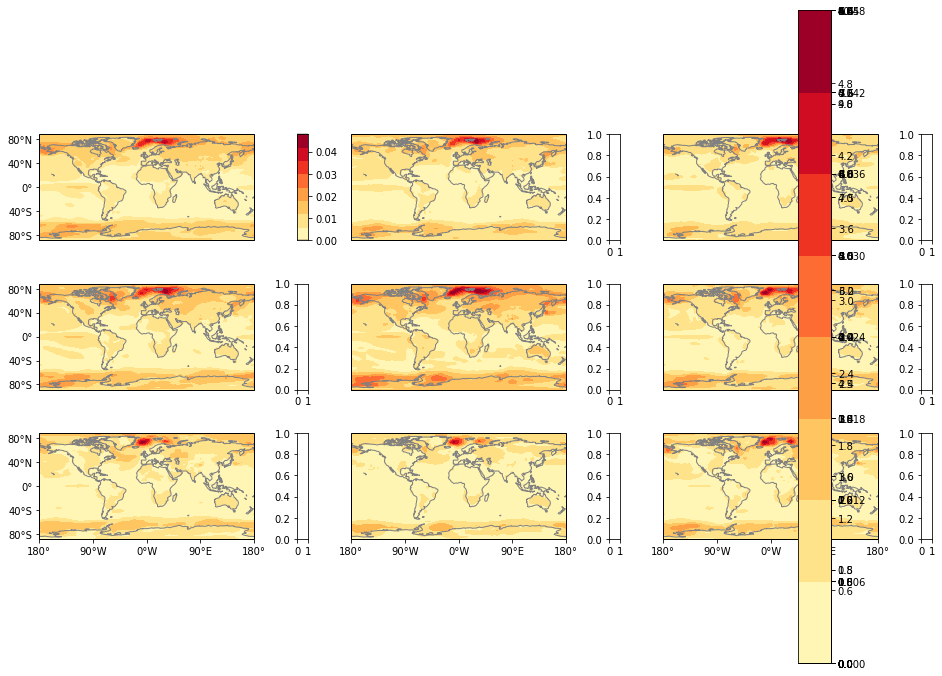

In [40]:
#cddp4=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_0.0_snr_0.4.npy')
cdd0=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_0.0_snr_100.0.npy')
ad = np.load('/Users/dan/Desktop/Nullspace/pt_out/ad.npy')
plot_3x3(cdd0,ad[0]['grid'])

